# Dictionary Learning 

In [51]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from dictionary import AutoEncoder

import matplotlib.pyplot as plt



In [3]:
# Load sentences from CSV file
df = pd.read_csv("sentences.csv", delimiter=",", encoding="utf-8", quotechar='"')
sentences = df['sentence'].tolist()

print(sentences)

['The capital of Russia is Moscow.', 'The capital of China is Beijing.', 'The capital of Greece is Athens.', 'The capital of Germany is Berlin.', 'The capital of France is Paris.', 'The capital of the United Kingdom is London.', 'The capital of Japan is Tokyo.', 'The capital of Egypt is Cairo.', 'The capital of Italy is Rome.', 'The capital of Spain is Madrid.', 'The capital of Portugal is Lisbon.', 'The capital of Canada is Ottawa.', 'The capital of Australia is Canberra.', 'The capital of Brazil is Brasília.', 'The capital of India is New Delhi.', 'The capital of the United States is Washington, D.C.', 'The capital of Argentina is Buenos Aires.', 'The capital of Mexico is Mexico City.', 'The capital of South Korea is Seoul.', 'The capital of Indonesia is Jakarta.', 'The capital of Thailand is Bangkok.', 'The capital of Norway is Oslo.', 'The capital of Sweden is Stockholm.', 'The capital of Finland is Helsinki.', 'The capital of Poland is Warsaw.', 'The capital of Austria is Vienna.'

In [4]:
# Load the Pythia model and tokenizer
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer.pad_token = tokenizer.eos_token

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [86]:
# Testing tokenizer 
sentence = "The capital of Russia is Moscow. Moscow is in Russia."
tokenized_sentence = tokenizer(sentence)['input_ids']
decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

print("Tokenized output:", decoded_tokens)

Tokenized output: ['The', 'Ġcapital', 'Ġof', 'ĠRussia', 'Ġis', 'ĠMoscow', '.', 'ĠMoscow', 'Ġis', 'Ġin', 'ĠRussia', '.']


In [25]:
activation_list = []

def hook_fn(module, input, output):
    """Hook function to capture activations from the 4th MLP layer."""
    activation_list.append(output)

# Hook 4th MLP layer (index 3)
layer_to_hook = model.gpt_neox.layers[5].mlp
hook = layer_to_hook.register_forward_hook(hook_fn)


In [26]:
# Store per-token activations
individual_activations = []
    
for sentence in sentences:
    print(f"\nProcessing: '{sentence}'")
    input_ids_batch = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    model(**input_ids_batch)  # Forward pass to capture activations

    if activation_list:
        activations = activation_list[-1].squeeze(0)  # Shape: (seq_len, hidden_dim)
        individual_activations.append(activations)
    activation_list.clear()

print(f"Captured activations for {len(individual_activations)} sentences.")



Processing: 'The capital of Russia is Moscow.'

Processing: 'The capital of China is Beijing.'

Processing: 'The capital of Greece is Athens.'

Processing: 'The capital of Germany is Berlin.'

Processing: 'The capital of France is Paris.'

Processing: 'The capital of the United Kingdom is London.'

Processing: 'The capital of Japan is Tokyo.'

Processing: 'The capital of Egypt is Cairo.'

Processing: 'The capital of Italy is Rome.'

Processing: 'The capital of Spain is Madrid.'

Processing: 'The capital of Portugal is Lisbon.'

Processing: 'The capital of Canada is Ottawa.'

Processing: 'The capital of Australia is Canberra.'

Processing: 'The capital of Brazil is Brasília.'

Processing: 'The capital of India is New Delhi.'

Processing: 'The capital of the United States is Washington, D.C.'

Processing: 'The capital of Argentina is Buenos Aires.'

Processing: 'The capital of Mexico is Mexico City.'

Processing: 'The capital of South Korea is Seoul.'

Processing: 'The capital of Indone

In [29]:
# Load Dictionary Learning AutoEncoder
ae = AutoEncoder.from_pretrained(
    "dictionaries/pythia-70m-deduped/mlp_out_layer5/10_32768/ae.pt", 
    map_location=torch.device('cpu')
)



In [32]:
# Convert activations to sparse representations
sparse_representations = []
for activations in individual_activations:
    sparse_repr = ae.encode(activations).detach().cpu().numpy()  # (seq_len, dict_size)
    sparse_representations.append(sparse_repr)
print(f"Processed {len(sparse_representations)} sentences into token-aligned sparse representations.")

Processed 26 sentences into token-aligned sparse representations.


In [58]:
# Aggregate features: Find top activated features across all tokens in all sentences
feature_counts = {}
for sentence_features in sparse_representations:
    for token_features in sentence_features:
        top_indices = np.argsort(token_features)[-3:][::-1]  # Top 800 features per token
        for idx in top_indices:
            feature_counts[idx] = feature_counts.get(idx, 0) + 1
            


(array([3., 2., 1., 3., 0., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1.]), array([0.42556709, 0.46641603, 0.50726497, 0.54811388, 0.58896279,
       0.62981176, 0.67066067, 0.71150959, 0.75235856, 0.79320753,
       0.83405644, 0.87490535, 0.91575432, 0.95660323, 0.99745214,
       1.03830111, 1.07914996, 1.11999893, 1.1608479 , 1.20169687,
       1.24254584, 1.28339469, 1.32424355, 1.36509252, 1.40594149,
       1.44679034]), <BarContainer object of 25 artists>)


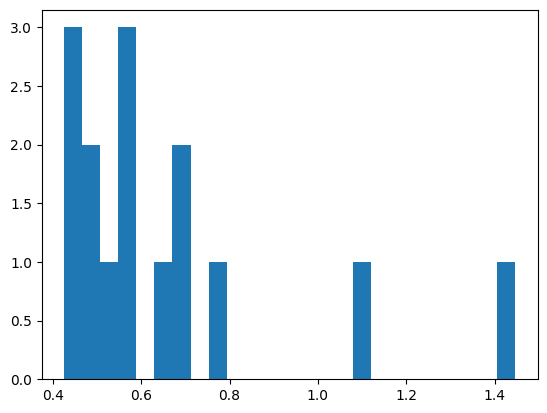

In [59]:
token_ind = 3

coeffs = []

for sentence_features in sparse_representations:
    for i, token_features in enumerate(sentence_features):
        top_indices = np.argsort(token_features)[-15:][::-1]  # Top 800 features per token
        coeffs.append([token_features[top_indices[j]] for j in range(len(top_indices))])

print()
print(plt.hist(coeffs[token_ind], bins=25))
        

In [92]:
# # Analyze which features activate for specific tokens
# top_n = 800  
# top_features = []

# for sentence_idx, per_token_features in enumerate(sparse_representations):
#     sentence_top_features = []
    
#     for token_idx, features in enumerate(per_token_features):
#         # Extract top N active features for this token
#         top_indices = np.argsort(features)[-top_n:][::-1]
#         sentence_top_features.append(set(top_indices))
    
#     top_features.append(sentence_top_features)  # Store per-token top feature indices

# # Example: Print feature activations for each token in the first sentence
# tokenized_sentence = tokenizer(sentences[0])['input_ids']
# decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

# print("\nFeature activations for the first sentence:")
# for token, feature_set in zip(decoded_tokens, top_features[0]):
#     print(f"Token: {token}, Top Features: {list(feature_set)[:10]}")  # Show top 5 features

#     # Example: Print feature activations for each token in the first sentence
# tokenized_sentence = tokenizer(sentences[1])['input_ids']
# decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

# print("\nFeature activations for the first sentence:")
# for token, feature_set in zip(decoded_tokens, top_features[0]):
#     print(f"Token: {token}, Top Features: {list(feature_set)[:10]}")  # Show top 5 features
    


In [61]:
# Select the most frequently occurring features
top_common_features = sorted(feature_counts, key=feature_counts.get, reverse=True)[:3]

# Create a synthetic sparse vector using these common features
synthetic_sparse_vector = np.zeros((32768,))  # Assume dictionary size is 32768
for idx in top_common_features:
    synthetic_sparse_vector[idx] = 1  # Set these features as active

In [62]:
# Decode sparse vector back into model space
synthetic_dense_vector = ae.decode(torch.tensor(synthetic_sparse_vector).float()).detach().cpu()
synthetic_dense_vector *= 0.1  # Experiment with scaling


In [63]:
# Add a new special token
tokenizer.add_special_tokens({'additional_special_tokens': ["<XYZ>"]})
model.resize_token_embeddings(len(tokenizer))  # Resize embeddings to include new token

masked_sentence = "The capital of <XYZ> is"
input_ids = tokenizer(masked_sentence, return_tensors="pt")["input_ids"]

# Convert token IDs to tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(f"Tokenized input: {decoded_tokens}")  # Debugging

# **Find the placeholder index**
try:
    placeholder_index = decoded_tokens.index("<XYZ>")
except ValueError:
    raise ValueError(f"Could not find placeholder token in: {decoded_tokens}")


Tokenized input: ['The', 'Ġcapital', 'Ġof', 'Ġ', '<XYZ>', 'Ġis']


In [64]:

# Convert input_ids to embeddings
model_inputs = model.get_input_embeddings()(input_ids)

# Inject synthetic feature vector at the placeholder position
model_inputs[:, placeholder_index, :] = synthetic_dense_vector

# Generate text from modified embeddings
with torch.no_grad():
    outputs = model(inputs_embeds=model_inputs)
    logits = outputs.logits[:, -1, :]  # Get last token logits
    predicted_token_id = torch.argmax(logits, dim=-1).item()

# Decode the predicted token
predicted_word = tokenizer.decode([predicted_token_id])

print(f"Predicted token: {predicted_word}")

Predicted token:  the


In [65]:
num_predictions = 100
prediction = []


for _ in range(num_predictions):
    with torch.no_grad():
        outputs = model(inputs_embeds=model_inputs)
        logits = outputs.logits[:, -1, :]  # Get last token logits
        predicted_token_id = torch.argmax(logits, dim=-1).item()
    prediction.append(tokenizer.decode([predicted_token_id]))



print(prediction)

[' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the']
